### import caffe

In [1]:
import os
import sys
import numpy as np
import cv2
import caffe
import dlib
import matplotlib.pyplot as plt
from math import sqrt
import cv2
from sklearn import *
from numpy import *
import glob

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Set Caffe environment for iTracker, apart from the path, you don't need to change anything.

In [2]:
# Install the Caffe, and put gazecapture (iTracker) inside the model directory
caffe_root='/Users/youhan/Documents/17-18/fyp/caffe-master/models/gazecapture/' 
#sys.path.insert(0, caffe_root + 'python')


In [3]:
import os
if os.path.isfile(caffe_root + 'snapshots/itracker25x_iter_92000.caffemodel'):
    print('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
caffe.set_mode_cpu()
model_def = caffe_root+'itracker_deploy.prototxt'
model_weights = caffe_root+'snapshots/itracker_iter_92000.caffemodel'



CaffeNet found.


In [4]:
net = caffe.Net(model_def,      # defines the structure of the model
            model_weights,  # contains the trained weights
            caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mleft = np.load(caffe_root + 'mean_images/left.npy')
mleft = mleft.mean(1).mean(1)  # average over pixels to obtain the mean (RGB) pixel values
print('mean-subtracted values:', zip('RGB', mleft))

mright = np.load(caffe_root + 'mean_images/right.npy')
mright = mright.mean(1).mean(1)  # average over pixels to obtain the mean (RGB) pixel values
print('mean-subtracted values:', zip('RGB', mright))

mface = np.load(caffe_root + 'mean_images/face.npy')
mface = mface.mean(1).mean(1)  # average over pixels to obtain the mean (RGB) pixel values
print('mean-subtracted values:', zip('RGB', mface))

# create transformer for the input called 'data'
transformerl = caffe.io.Transformer({'image_left': net.blobs['image_left'].data.shape})
transformer2 = caffe.io.Transformer({'image_right': net.blobs['image_right'].data.shape})
transformer3 = caffe.io.Transformer({'image_face': net.blobs['image_face'].data.shape})
transformer4= caffe.io.Transformer({'facegrid': net.blobs['facegrid'].data.shape})

transformerl.set_transpose('image_left', (2,0,1))  # move image channels to outermost dimension
transformer2.set_transpose('image_right', (2,0,1))  # move image channels to outermost dimension
transformer3.set_transpose('image_face', (2,0,1))  # move image channels to outermost dimension
transformer4.set_transpose('facegrid', (2,0,1))

transformerl.set_mean('image_left', mleft)            # subtract the dataset-mean value in each channel
transformer2.set_mean('image_right', mright)            # subtract the dataset-mean value in each channel
transformer3.set_mean('image_face', mface)            # subtract the dataset-mean value in each channel

transformerl.set_raw_scale('image_left', 255)
transformer2.set_raw_scale('image_right', 255) 
transformer3.set_raw_scale('image_face', 255) 
#transformer4.set_raw_scale('facegrid', 255) 

# rescale from [0, 1] to [0, 255]
transformerl.set_channel_swap('image_left', (2,1,0))
transformer2.set_channel_swap('image_right', (2,1,0)) 
transformer3.set_channel_swap('image_face', (2,1,0))


('mean-subtracted values:', [('R', 97.515486925080126), ('G', 105.81451976649006), ('B', 141.64970855947053)])
('mean-subtracted values:', [('R', 93.259237833473136), ('G', 102.0830842169876), ('B', 135.04557388640788)])
('mean-subtracted values:', [('R', 100.96920115044531), ('G', 112.32869105208285), ('B', 148.36621669953573)])


In [6]:
def processBatch(imgsl,imgsr,imgsf,grids,net):
    imgs_l=[];imgs_r=[];imgs_f=[];imgs_g=[]
    for i in range(len(imgsl)):
        net.blobs['image_left'].data[...][i] = transformerl.preprocess('image_left',imgsl[i])

        net.blobs['image_right'].data[...][i] = transformer2.preprocess('image_right',imgsr[i])

        net.blobs['image_face'].data[...][i] = transformer3.preprocess('image_face',imgsf[i])
    
        net.blobs['facegrid'].data[...] = transformer4.preprocess('facegrid',grids[i])
        print(i)
    return net


## Generate 34 points needed for Calibration

In [7]:
import os.path
#Calibration for iTracker
home='/Users/youhan/Documents/FYP/mapping_data/' # Home directory
name='you7' # Dataset directory
path=home+name
flist=glob.glob(path+"/raw/*")
cali_n=len(flist)
imleft=[]
imright=[]
imface=[]
masks=[]

In [ ]:
import os.path
#Calibration for iTracker
home='/Users/youhan/Documents/FYP/mapping_data'
name='you7'
path=home+name
flist=glob.glob(path+"/raw/*")
cali_n=len(flist)-25
imleft=[]
imright=[]
imface=[]
masks=[]

net.blobs['image_left'].reshape(cali_n,        # batch size
                      3,         # 3-channel (RGB) images
                      224, 224)  # image size is 227x227
net.blobs['image_right'].reshape(cali_n,        # batch size
                          3,         # 3-channel (RGB) images
                          224, 224)  # image size is 227x227
net.blobs['image_face'].reshape(cali_n,        # batch size
                          3,         # 3-channel (RGB) images
                          224, 224)  # image size is 227x227
net.blobs['facegrid'].reshape(cali_n,
                              625
                              ,1,1)

In [ ]:

for i in range(0,cali_n):
    imleft.append(caffe.io.load_image(path+'/eyeLeft/f'+str(i)+'eye2.jpg'))
    #print net.blobs['image_left'].data[0][0][0][0:3]

    imright.append(caffe.io.load_image(path+'/eyeRight/f'+str(i)+'eye1.jpg'))

    imface.append(caffe.io.load_image(path+'/face/face'+str(i)+'.jpg'))

    with open(path+'/grid/face_grid'+str(i), 'r') as myfile:
        data=myfile.read().replace('\n', '')
        mask=data.split()
        #mask=[[mask]]
        mask=list(zip(list(zip(mask))))
        masks.append(np.array(mask))


net=processBatch(imleft,imright,imface,masks,net)
data=net.forward()

The raw predictions from iTracker is in cm, as it's originally trained for mobile phone

In [8]:
print("    x        y") # relative to the camera
to_file=[]
for i in range(0,cali_n):
    #line= "%-2d  %.6s   %.6s     %-4s         %-4s " %(i+1, str(data['fc3'][i][0]), \
    #                                                   str(data['fc3'][i][1]), g_truth[i][0], g_truth[i][1])
    line= "%-2d  %.6s   %.6s" %(i+1, str(data['fc3'][i][0]), \
                                                       str(data['fc3'][i][1]))
    print(line)
    to_file.append(line)
'''
f = open(path+name+"_reference_table.txt", 'w')
[f.write(i+"\n") for i in to_file]  # python will convert \n to os.linesep
f.close()'''

    x        y
1   -9.613   -1.043
2   1.2769   -4.004
3   11.549   -1.221
4   -7.447   -9.914
5   2.2996   -10.44
6   10.341   -8.049
7   -6.519   -18.51
8   1.4788   -16.49
9   7.9138   -13.36
10  -3.119   -7.922
11  6.4537   -5.578
12  -3.241   -14.85
13  6.3277   -14.78
14  -3.806   -2.153
15  6.1385   -0.909
16  -3.529   -10.26
17  5.4892   -9.896
18  -3.279   -17.73
19  5.6764   -15.85
20  -8.783   -4.979
21  1.8977   -6.678
22  11.051   -3.619
23  -5.987   -15.15
24  3.6201   -15.07
25  8.8403   -12.80
26  -9.526   -1.680
27  1.6019   -3.069
28  11.108   -1.035
29  -7.241   -10.02
30  2.4835   -9.855
31  9.9610   -6.986
32  -5.526   -18.10
33  1.8676   -17.31
34  7.9592   -13.72


'\nf = open(path+name+"_reference_table.txt", \'w\')\n[f.write(i+"\n") for i in to_file]  # python will convert \n to os.linesep\nf.close()'

## Use Linear/Ridge Regression to map the predicted value in cm to value in pixels

In [9]:
##load ground truth
import csv

with open('/home/gtx1080ti/Documents/hanyou2/work/cali_points') as f:
    lines = f.read().splitlines()
g_truth=[]
for i in lines:
    g_truth.append((int(i.split(" ")[0]),int(i.split(" ")[1])))
    
m=34#number of calibration points
trainX=[data['fc3'][i] for i in range(0,m)]
testX=[data['fc3'][i] for i in range(m,cali_n)]
trainY=[g_truth[i] for i in range(0,m)]
testY=[g_truth[i] for i in range(m,cali_n)]


#logreg = kernel_ridge.KernelRidge(alpha=1,kernel='poly',degree=2)
logreg = linear_model.LinearRegression()

logreg.fit(trainX, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Plot the raw predictions (in cm for mobile phone)

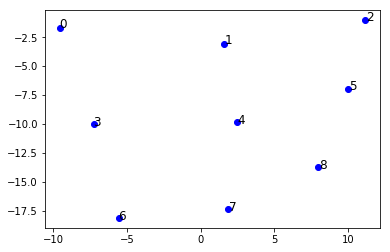

In [10]:
x_s=[]
y_s=[]
for i in range(0,9):
    x_s.append(data['fc3'][i+25][0])
    y_s.append(data['fc3'][i+25][1])

for i in range(0,9):
    x = x_s[i]
    y = y_s[i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
plt.show()

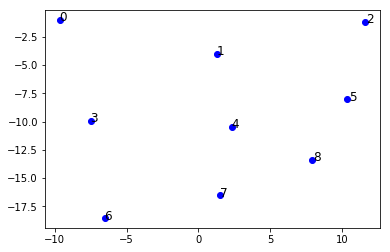

In [11]:
x_s=[]
y_s=[]
m=25
for i in range(0,cali_n-m):
    x_s.append(data['fc3'][i][0])
    y_s.append(data['fc3'][i][1])

for i in range(0,cali_n-m):
    x = x_s[i]
    y = y_s[i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
plt.show()

### Predicting using all the frames in the input video

Given this video, want to get all the prediction results of it, which is {L{0), L(1),....L(t)}

In [13]:
net1 = caffe.Net(model_def,      # defines the structure of the model
            model_weights,  # contains the trained weights
            caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [14]:
#Test all the data for iTracker
path='/home/gtx1080ti/Documents/hanyou2/0206/'+name
flist=glob.glob(path+"/raw/*")
n=len(flist)
imleft=[]
imright=[]
imface=[]
masks=[]
#with open('/Users/youhan/Documents/FYP/work/points34') as f:
#    lines = f.read().splitlines()
#g_truth=[]
#for i in lines:
#    g_truth.append((int(i.split(" ")[1]),int(i.split(" ")[2])))
size=100

net1.blobs['image_left'].reshape(size,        # batch size
                      3,         # 3-channel (RGB) images
                      224, 224)  # image size is 227x227
net1.blobs['image_right'].reshape(size,        # batch size
                          3,         # 3-channel (RGB) images
                          224, 224)  # image size is 227x227
net1.blobs['image_face'].reshape(size,        # batch size
                          3,         # 3-channel (RGB) images
                          224, 224)  # image size is 227x227
net1.blobs['facegrid'].reshape(size,
                              625
                              ,1,1)
#raw img id start from 1 in the directory!


number of frames in this input video

In [15]:
n

21155

Get all the predictions now

In [16]:
positions=[]
for i in range(0,211):
    imleft=[]
    imright=[]
    imface=[]
    masks=[]
    img_index=[]
    for j in range(100*i,100*i+100,2):
        print(j)
        if (os.path.exists(path+'/eyeLeft/f'+str(j)+'eye2.jpg') and
            os.path.exists(path+'/eyeRight/f'+str(j)+'eye1.jpg') and
            os.path.exists(path+'/face/face'+str(j)+'.jpg') and      
            os.path.exists(path+'/grid/face_grid'+str(j))):
            print('^^^^')    
            imleft.append(caffe.io.load_image(path+'/eyeLeft/f'+str(j)+'eye2.jpg'))
            #print net.blobs['image_left'].data[0][0][0][0:3]

            imright.append(caffe.io.load_image(path+'/eyeRight/f'+str(j)+'eye1.jpg'))

            imface.append(caffe.io.load_image(path+'/face/face'+str(j)+'.jpg'))
            img_index.append(j)
            with open(path+'/grid/face_grid'+str(j), 'r') as myfile:
                data1=myfile.read().replace('\n', '')
                mask=data1.split()
                #mask=[[mask]]
                mask=list(zip(list(zip(mask))))
                masks.append(np.array(mask))
    net1=processBatch(imleft,imright,imface,masks,net1)
    data1=net1.forward()

    for j in range(0,len(imleft)):
        #line= "%-2d  %.6s   %.6s     %-4s         %-4s " %(i+1, str(data['fc3'][i][0]), \
        #                                                   str(data['fc3'][i][1]), g_truth[i][0], g_truth[i][1])
        positions.append((img_index[j], data1['fc3'][j][0], data1['fc3'][j][1]))


0
^^^^
2
^^^^
4
^^^^
6
^^^^
8
^^^^
10
^^^^
12
^^^^
14
^^^^
16
^^^^
18
^^^^
20
^^^^
22
^^^^
24
^^^^
26
^^^^
28
^^^^
30
^^^^
32
^^^^
34
^^^^
36
^^^^
38
^^^^
40
^^^^
42
^^^^
44
^^^^
46
^^^^
48
^^^^
50
^^^^
52
^^^^
54
^^^^
56
^^^^
58
^^^^
60
^^^^
62
^^^^
64
^^^^
66
^^^^
68
^^^^
70
^^^^
72
^^^^
74
^^^^
76
^^^^
78
^^^^
80
^^^^
82
^^^^
84
^^^^
86
^^^^
88
^^^^
90
^^^^
92
^^^^
94
^^^^
96
^^^^
98
^^^^


/usr/lib/python3/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
100
^^^^
102
^^^^
104
^^^^
106
^^^^
108
^^^^
110
^^^^
112
^^^^
114
^^^^
116
^^^^
118
^^^^
120
^^^^
122
^^^^
124
^^^^
126
^^^^
128
^^^^
130
^^^^
132
^^^^
134
^^^^
136
^^^^
138
^^^^
140
^^^^
142
^^^^
144
^^^^
146
^^^^
148
^^^^
150
^^^^
152
^^^^
154
^^^^
156
^^^^
158
^^^^
160
^^^^
162
^^^^
164
^^^^
166
^^^^
168
^^^^
170
^^^^
172
^^^^
174
^^^^
176
^^^^
178
^^^^
180
^^^^
182
^^^^
184
^^^^
186
^^^^
188
^^^^
190
^^^^
192
^^^^
194
^^^^
196
^^^^
198
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
200
^^^^
202
^^^^
204
^^^^
206
^^^^
208
^^^^
210
^^^^
212
^^^^
214
^^^^
216
^^^^
218
^^^^
220
^^^^
222
^^^^
224
^^^^
226
^^^^
228
^^^^
230
^^^^
232
^^^^
234
^^^^
236
^^^^
238
^^^^
240
^^^^
242
^^^^
244
^^^^
246
^^^^
248
^^^^
250
^^^^
252
^^^^
254
^^^^
256
^^^^
258
^^^^


1450
^^^^
1452
^^^^
1454
^^^^
1456
^^^^
1458
^^^^
1460
^^^^
1462
^^^^
1464
^^^^
1466
^^^^
1468
^^^^
1470
^^^^
1472
^^^^
1474
^^^^
1476
^^^^
1478
^^^^
1480
^^^^
1482
^^^^
1484
^^^^
1486
^^^^
1488
^^^^
1490
^^^^
1492
^^^^
1494
^^^^
1496
^^^^
1498
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
1500
^^^^
1502
^^^^
1504
^^^^
1506
^^^^
1508
^^^^
1510
^^^^
1512
^^^^
1514
^^^^
1516
^^^^
1518
^^^^
1520
^^^^
1522
^^^^
1524
^^^^
1526
^^^^
1528
^^^^
1530
^^^^
1532
^^^^
1534
^^^^
1536
^^^^
1538
^^^^
1540
^^^^
1542
^^^^
1544
^^^^
1546
^^^^
1548
^^^^
1550
^^^^
1552
^^^^
1554
^^^^
1556
^^^^
1558
^^^^
1560
^^^^
1562
^^^^
1564
^^^^
1566
^^^^
1568
^^^^
1570
^^^^
1572
^^^^
1574
^^^^
1576
^^^^
1578
^^^^
1580
^^^^
1582
^^^^
1584
^^^^
1586
^^^^
1588
^^^^
1590
^^^^
1592
^^^^
1594
^^^^
1596
^^^^
1598
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


2748
^^^^
2750
^^^^
2752
^^^^
2754
^^^^
2756
^^^^
2758
^^^^
2760
^^^^
2762
^^^^
2764
^^^^
2766
^^^^
2768
^^^^
2770
^^^^
2772
^^^^
2774
^^^^
2776
^^^^
2778
^^^^
2780
^^^^
2782
^^^^
2784
^^^^
2786
^^^^
2788
^^^^
2790
^^^^
2792
^^^^
2794
^^^^
2796
^^^^
2798
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2800
^^^^
2802
^^^^
2804
^^^^
2806
^^^^
2808
^^^^
2810
^^^^
2812
^^^^
2814
^^^^
2816
^^^^
2818
^^^^
2820
^^^^
2822
^^^^
2824
^^^^
2826
^^^^
2828
^^^^
2830
^^^^
2832
^^^^
2834
^^^^
2836
^^^^
2838
^^^^
2840
^^^^
2842
^^^^
2844
^^^^
2846
^^^^
2848
^^^^
2850
^^^^
2852
^^^^
2854
^^^^
2856
^^^^
2858
^^^^
2860
^^^^
2862
^^^^
2864
^^^^
2866
^^^^
2868
^^^^
2870
^^^^
2872
^^^^
2874
^^^^
2876
^^^^
2878
^^^^
2880
^^^^
2882
^^^^
2884
^^^^
2886
^^^^
2888
^^^^
2890
^^^^
2892
^^^^
2894
^^^^
2896
^^^^
2898
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36

4050
^^^^
4052
^^^^
4054
^^^^
4056
^^^^
4058
^^^^
4060
^^^^
4062
^^^^
4064
^^^^
4066
^^^^
4068
^^^^
4070
^^^^
4072
^^^^
4074
^^^^
4076
^^^^
4078
^^^^
4080
^^^^
4082
^^^^
4084
^^^^
4086
^^^^
4088
^^^^
4090
^^^^
4092
^^^^
4094
^^^^
4096
^^^^
4098
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
4100
^^^^
4102
^^^^
4104
^^^^
4106
^^^^
4108
^^^^
4110
^^^^
4112
^^^^
4114
^^^^
4116
^^^^
4118
^^^^
4120
^^^^
4122
^^^^
4124
^^^^
4126
^^^^
4128
^^^^
4130
^^^^
4132
^^^^
4134
^^^^
4136
^^^^
4138
^^^^
4140
^^^^
4142
^^^^
4144
^^^^
4146
^^^^
4148
^^^^
4150
^^^^
4152
^^^^
4154
^^^^
4156
^^^^
4158
^^^^
4160
^^^^
4162
^^^^
4164
^^^^
4166
^^^^
4168
^^^^
4170
^^^^
4172
^^^^
4174
^^^^
4176
^^^^
4178
^^^^
4180
^^^^
4182
^^^^
4184
^^^^
4186
^^^^
4188
^^^^
4190
^^^^
4192
^^^^
4194
^^^^
4196
^^^^
4198
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


^^^^
5352
^^^^
5354
^^^^
5356
^^^^
5358
^^^^
5360
^^^^
5362
^^^^
5364
^^^^
5366
^^^^
5368
^^^^
5370
^^^^
5372
^^^^
5374
^^^^
5376
^^^^
5378
^^^^
5380
^^^^
5382
^^^^
5384
^^^^
5386
^^^^
5388
^^^^
5390
^^^^
5392
^^^^
5394
^^^^
5396
^^^^
5398
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
5400
^^^^
5402
^^^^
5404
^^^^
5406
^^^^
5408
^^^^
5410
^^^^
5412
^^^^
5414
^^^^
5416
^^^^
5418
^^^^
5420
^^^^
5422
^^^^
5424
^^^^
5426
^^^^
5428
^^^^
5430
^^^^
5432
^^^^
5434
^^^^
5436
^^^^
5438
^^^^
5440
^^^^
5442
^^^^
5444
^^^^
5446
^^^^
5448
^^^^
5450
^^^^
5452
^^^^
5454
^^^^
5456
^^^^
5458
^^^^
5460
^^^^
5462
^^^^
5464
^^^^
5466
^^^^
5468
^^^^
5470
^^^^
5472
^^^^
5474
^^^^
5476
^^^^
5478
^^^^
5480
^^^^
5482
^^^^
5484
^^^^
5486
^^^^
5488
^^^^
5490
^^^^
5492
^^^^
5494
^^^^
5496
^^^^
5498
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41

6650
^^^^
6652
^^^^
6654
^^^^
6656
^^^^
6658
^^^^
6660
^^^^
6662
^^^^
6664
^^^^
6666
^^^^
6668
^^^^
6670
^^^^
6672
^^^^
6674
^^^^
6676
^^^^
6678
^^^^
6680
^^^^
6682
^^^^
6684
^^^^
6686
^^^^
6688
^^^^
6690
^^^^
6692
^^^^
6694
^^^^
6696
^^^^
6698
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
6700
^^^^
6702
^^^^
6704
^^^^
6706
^^^^
6708
^^^^
6710
^^^^
6712
^^^^
6714
^^^^
6716
^^^^
6718
^^^^
6720
^^^^
6722
^^^^
6724
^^^^
6726
^^^^
6728
^^^^
6730
^^^^
6732
^^^^
6734
^^^^
6736
^^^^
6738
^^^^
6740
^^^^
6742
^^^^
6744
^^^^
6746
^^^^
6748
^^^^
6750
^^^^
6752
^^^^
6754
^^^^
6756
^^^^
6758
^^^^
6760
^^^^
6762
^^^^
6764
^^^^
6766
^^^^
6768
^^^^
6770
^^^^
6772
^^^^
6774
^^^^
6776
^^^^
6778
^^^^
6780
^^^^
6782
^^^^
6784
^^^^
6786
^^^^
6788
^^^^
6790
^^^^
6792
^^^^
6794
^^^^
6796
^^^^
6798
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


7950
^^^^
7952
^^^^
7954
^^^^
7956
^^^^
7958
^^^^
7960
^^^^
7962
^^^^
7964
^^^^
7966
^^^^
7968
^^^^
7970
^^^^
7972
^^^^
7974
^^^^
7976
^^^^
7978
^^^^
7980
^^^^
7982
^^^^
7984
^^^^
7986
^^^^
7988
^^^^
7990
^^^^
7992
^^^^
7994
^^^^
7996
^^^^
7998
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
8000
^^^^
8002
^^^^
8004
^^^^
8006
^^^^
8008
^^^^
8010
^^^^
8012
^^^^
8014
^^^^
8016
^^^^
8018
^^^^
8020
^^^^
8022
^^^^
8024
^^^^
8026
^^^^
8028
^^^^
8030
^^^^
8032
^^^^
8034
^^^^
8036
^^^^
8038
^^^^
8040
^^^^
8042
^^^^
8044
^^^^
8046
^^^^
8048
^^^^
8050
^^^^
8052
^^^^
8054
^^^^
8056
^^^^
8058
^^^^
8060
^^^^
8062
^^^^
8064
^^^^
8066
^^^^
8068
^^^^
8070
^^^^
8072
^^^^
8074
^^^^
8076
^^^^
8078
^^^^
8080
^^^^
8082
^^^^
8084
^^^^
8086
^^^^
8088
^^^^
8090
^^^^
8092
^^^^
8094
^^^^
8096
^^^^
8098
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


9248
^^^^
9250
^^^^
9252
^^^^
9254
^^^^
9256
^^^^
9258
^^^^
9260
^^^^
9262
^^^^
9264
^^^^
9266
^^^^
9268
^^^^
9270
^^^^
9272
^^^^
9274
^^^^
9276
^^^^
9278
^^^^
9280
^^^^
9282
^^^^
9284
^^^^
9286
^^^^
9288
^^^^
9290
^^^^
9292
^^^^
9294
^^^^
9296
^^^^
9298
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
9300
^^^^
9302
^^^^
9304
^^^^
9306
^^^^
9308
^^^^
9310
^^^^
9312
^^^^
9314
^^^^
9316
^^^^
9318
^^^^
9320
^^^^
9322
^^^^
9324
^^^^
9326
^^^^
9328
^^^^
9330
^^^^
9332
^^^^
9334
^^^^
9336
^^^^
9338
^^^^
9340
^^^^
9342
^^^^
9344
^^^^
9346
^^^^
9348
^^^^
9350
^^^^
9352
^^^^
9354
^^^^
9356
^^^^
9358
^^^^
9360
^^^^
9362
^^^^
9364
^^^^
9366
^^^^
9368
^^^^
9370
^^^^
9372
^^^^
9374
^^^^
9376
^^^^
9378
^^^^
9380
^^^^
9382
^^^^
9384
^^^^
9386
^^^^
9388
^^^^
9390
^^^^
9392
^^^^
9394
^^^^
9396
^^^^
9398
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
10500
^^^^
10502
^^^^
10504
^^^^
10506
^^^^
10508
^^^^
10510
^^^^
10512
^^^^
10514
^^^^
10516
^^^^
10518
^^^^
10520
^^^^
10522
^^^^
10524
^^^^
10526
^^^^
10528
^^^^
10530
^^^^
10532
^^^^
10534
^^^^
10536
^^^^
10538
^^^^
10540
^^^^
10542
^^^^
10544
^^^^
10546
^^^^
10548
^^^^
10550
^^^^
10552
^^^^
10554
^^^^
10556
^^^^
10558
^^^^
10560
^^^^
10562
^^^^
10564
^^^^
10566
^^^^
10568
^^^^
10570
^^^^
10572
^^^^
10574
^^^^
10576
^^^^
10578
^^^^
10580
^^^^
10582
^^^^
10584
^^^^
10586
^^^^
10588
^^^^
10590
^^^^
10592
^^^^
10594
^^^^
10596
^^^^
10598
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
10600
^^^^
10602
^^^^
10604
^^^^
10606
^^^^
10608
^^^^
10610
^^^^
10612
^^^^
10614
^^^^
10616
^^^^
10618
^^^^
10620
^^^^
10622
^^^^
10624
^^^^
10626
^^^^
10628
^^^^
10630
^^^^
10632
^^^^
10634
^^^^
10636
^^^^
10638
^^^^
10640
^^^^
1064

11696
^^^^
11698
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
11700
^^^^
11702
^^^^
11704
^^^^
11706
^^^^
11708
^^^^
11710
^^^^
11712
^^^^
11714
^^^^
11716
^^^^
11718
^^^^
11720
^^^^
11722
^^^^
11724
^^^^
11726
^^^^
11728
^^^^
11730
^^^^
11732
^^^^
11734
^^^^
11736
^^^^
11738
^^^^
11740
^^^^
11742
^^^^
11744
^^^^
11746
^^^^
11748
^^^^
11750
^^^^
11752
^^^^
11754
^^^^
11756
^^^^
11758
^^^^
11760
^^^^
11762
^^^^
11764
^^^^
11766
^^^^
11768
^^^^
11770
^^^^
11772
^^^^
11774
^^^^
11776
^^^^
11778
^^^^
11780
^^^^
11782
^^^^
11784
^^^^
11786
^^^^
11788
^^^^
11790
^^^^
11792
^^^^
11794
^^^^
11796
^^^^
11798
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
11800
^^^^
11802
^^^^
11804
^^^^
11806
^^^^
11808
^^^^
11810
^^^^
11812
^^^^
11814
^^^^
11816
^^^^
11818
^^^^
11820
^^^^
11822
^^^^
11824
^^^^
11826

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
12900
^^^^
12902
^^^^
12904
^^^^
12906
^^^^
12908
^^^^
12910
^^^^
12912
^^^^
12914
^^^^
12916
^^^^
12918
^^^^
12920
^^^^
12922
^^^^
12924
^^^^
12926
^^^^
12928
^^^^
12930
^^^^
12932
^^^^
12934
^^^^
12936
^^^^
12938
^^^^
12940
^^^^
12942
^^^^
12944
^^^^
12946
^^^^
12948
^^^^
12950
^^^^
12952
^^^^
12954
^^^^
12956
^^^^
12958
^^^^
12960
^^^^
12962
^^^^
12964
^^^^
12966
^^^^
12968
^^^^
12970
^^^^
12972
^^^^
12974
^^^^
12976
^^^^
12978
^^^^
12980
^^^^
12982
^^^^
12984
^^^^
12986
^^^^
12988
^^^^
12990
^^^^
12992
^^^^
12994
^^^^
12996
^^^^
12998
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
13000
^^^^
13002
^^^^
13004
^^^^
13006
^^^^
13008
^^^^
13010
^^^^
13012
^^^^
13014
^^^^
13016
^^^^
13018
^^^^
13020
^^^^
13022
^^^^
13024
^^^^
13026
^^^^
13028
^^^^
13030

14098
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
14100
^^^^
14102
^^^^
14104
^^^^
14106
^^^^
14108
^^^^
14110
^^^^
14112
^^^^
14114
^^^^
14116
^^^^
14118
^^^^
14120
^^^^
14122
^^^^
14124
^^^^
14126
^^^^
14128
^^^^
14130
^^^^
14132
^^^^
14134
^^^^
14136
^^^^
14138
^^^^
14140
^^^^
14142
^^^^
14144
^^^^
14146
^^^^
14148
^^^^
14150
^^^^
14152
^^^^
14154
^^^^
14156
^^^^
14158
^^^^
14160
^^^^
14162
^^^^
14164
^^^^
14166
^^^^
14168
^^^^
14170
^^^^
14172
^^^^
14174
^^^^
14176
^^^^
14178
^^^^
14180
^^^^
14182
^^^^
14184
^^^^
14186
^^^^
14188
^^^^
14190
^^^^
14192
^^^^
14194
^^^^
14196
^^^^
14198
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
14200
^^^^
14202
^^^^
14204
^^^^
14206
^^^^
14208
^^^^
14210
^^^^
14212
^^^^
14214
^^^^
14216
^^^^
14218
^^^^
14220
^^^^
14222
^^^^
14224
^^^^
14226
^^^^
14228

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
15300
^^^^
15302
^^^^
15304
^^^^
15306
^^^^
15308
^^^^
15310
^^^^
15312
^^^^
15314
^^^^
15316
^^^^
15318
^^^^
15320
^^^^
15322
^^^^
15324
^^^^
15326
^^^^
15328
^^^^
15330
^^^^
15332
^^^^
15334
^^^^
15336
^^^^
15338
^^^^
15340
^^^^
15342
^^^^
15344
^^^^
15346
^^^^
15348
^^^^
15350
^^^^
15352
^^^^
15354
^^^^
15356
^^^^
15358
^^^^
15360
^^^^
15362
^^^^
15364
^^^^
15366
^^^^
15368
^^^^
15370
^^^^
15372
^^^^
15374
^^^^
15376
^^^^
15378
^^^^
15380
^^^^
15382
^^^^
15384
^^^^
15386
^^^^
15388
^^^^
15390
^^^^
15392
^^^^
15394
^^^^
15396
^^^^
15398
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
15400
^^^^
15402
^^^^
15404
^^^^
15406
^^^^
15408
^^^^
15410
^^^^
15412
^^^^
15414
^^^^
15416
^^^^
15418
^^^^
15420
^^^^
15422
^^^^
15424
^^^^
15426
^^^^
15428
^^^^
15430

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
16500
^^^^
16502
^^^^
16504
^^^^
16506
^^^^
16508
^^^^
16510
^^^^
16512
^^^^
16514
^^^^
16516
^^^^
16518
^^^^
16520
^^^^
16522
^^^^
16524
^^^^
16526
^^^^
16528
^^^^
16530
^^^^
16532
^^^^
16534
^^^^
16536
^^^^
16538
^^^^
16540
^^^^
16542
^^^^
16544
^^^^
16546
^^^^
16548
^^^^
16550
^^^^
16552
^^^^
16554
^^^^
16556
^^^^
16558
^^^^
16560
^^^^
16562
^^^^
16564
^^^^
16566
^^^^
16568
^^^^
16570
^^^^
16572
^^^^
16574
^^^^
16576
^^^^
16578
^^^^
16580
^^^^
16582
^^^^
16584
^^^^
16586
^^^^
16588
^^^^
16590
^^^^
16592
^^^^
16594
^^^^
16596
^^^^
16598
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
16600
^^^^
16602
^^^^
16604
^^^^
16606
^^^^
16608
^^^^
16610
^^^^
16612
^^^^
16614
^^^^
16616
^^^^
16618
^^^^
16620
^^^^
16622
^^^^
16624
^^^^
16626
^^^^
16628
^^^^
16630

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
17700
^^^^
17702
^^^^
17704
^^^^
17706
^^^^
17708
^^^^
17710
^^^^
17712
^^^^
17714
^^^^
17716
^^^^
17718
^^^^
17720
^^^^
17722
^^^^
17724
^^^^
17726
^^^^
17728
^^^^
17730
^^^^
17732
^^^^
17734
^^^^
17736
^^^^
17738
^^^^
17740
^^^^
17742
^^^^
17744
^^^^
17746
^^^^
17748
^^^^
17750
^^^^
17752
^^^^
17754
^^^^
17756
^^^^
17758
^^^^
17760
^^^^
17762
^^^^
17764
^^^^
17766
^^^^
17768
^^^^
17770
^^^^
17772
^^^^
17774
^^^^
17776
^^^^
17778
^^^^
17780
^^^^
17782
^^^^
17784
^^^^
17786
^^^^
17788
^^^^
17790
^^^^
17792
^^^^
17794
^^^^
17796
^^^^
17798
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
17800
^^^^
17802
^^^^
17804
^^^^
17806
^^^^
17808
^^^^
17810
^^^^
17812
^^^^
17814
^^^^
17816
^^^^
17818
^^^^
17820
^^^^
17822
^^^^
17824
^^^^
17826
^^^^
17828
^^^^
17830
^

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
18900
^^^^
18902
^^^^
18904
^^^^
18906
^^^^
18908
^^^^
18910
^^^^
18912
^^^^
18914
^^^^
18916
^^^^
18918
^^^^
18920
^^^^
18922
^^^^
18924
^^^^
18926
^^^^
18928
^^^^
18930
^^^^
18932
^^^^
18934
^^^^
18936
^^^^
18938
^^^^
18940
^^^^
18942
^^^^
18944
^^^^
18946
^^^^
18948
^^^^
18950
^^^^
18952
^^^^
18954
^^^^
18956
^^^^
18958
^^^^
18960
^^^^
18962
^^^^
18964
^^^^
18966
^^^^
18968
^^^^
18970
^^^^
18972
^^^^
18974
^^^^
18976
^^^^
18978
^^^^
18980
^^^^
18982
^^^^
18984
^^^^
18986
^^^^
18988
^^^^
18990
^^^^
18992
^^^^
18994
^^^^
18996
^^^^
18998
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
19000
^^^^
19002
^^^^
19004
^^^^
19006
^^^^
19008
^^^^
19010
^^^^
19012
^^^^
19014
^^^^
19016
^^^^
19018
^^^^
19020
^^^^
19022
^^^^
19024
^^^^
19026
^^^^
19028
^^^^
19030
^^^

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
20100
^^^^
20102
^^^^
20104
^^^^
20106
^^^^
20108
^^^^
20110
^^^^
20112
^^^^
20114
^^^^
20116
^^^^
20118
^^^^
20120
^^^^
20122
^^^^
20124
^^^^
20126
^^^^
20128
^^^^
20130
^^^^
20132
^^^^
20134
^^^^
20136
^^^^
20138
^^^^
20140
^^^^
20142
^^^^
20144
^^^^
20146
^^^^
20148
^^^^
20150
^^^^
20152
^^^^
20154
^^^^
20156
^^^^
20158
^^^^
20160
^^^^
20162
^^^^
20164
^^^^
20166
^^^^
20168
^^^^
20170
^^^^
20172
^^^^
20174
^^^^
20176
^^^^
20178
^^^^
20180
^^^^
20182
^^^^
20184
^^^^
20186
^^^^
20188
^^^^
20190
^^^^
20192
^^^^
20194
^^^^
20196
^^^^
20198
^^^^
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
20200
^^^^
20202
^^^^
20204
^^^^
20206
^^^^
20208
^^^^
20210
^^^^
20212
^^^^
20214
^^^^
20216
^^^^
20218
^^^^
20220
^^^^
20222
^^^^
20224
^^^^
20226
^^^^
20228
^^^^
20230

In [17]:
print(len(positions))
for i in range(len(positions)):
    print(positions[i])
positionss=[]
for i in range(0,len(positions)):
    positionss.append((int(positions[i][0]/2),positions[i][1],positions[i][2]))
len(positionss)

10550
(0, -4.180704, -6.1197133)
(2, -4.548054, -5.8858624)
(4, -6.0655437, -5.280764)
(6, -7.0778446, -3.4131436)
(8, -7.557426, -2.3819776)
(10, -7.5424447, -2.43815)
(12, -6.7535667, -2.932815)
(14, -6.4060006, -3.3427477)
(16, -5.9548435, -3.5075264)
(18, -6.851412, -2.880149)
(20, -6.831252, -2.8646326)
(22, -6.758685, -3.124886)
(24, -4.37743, -4.0348797)
(26, -4.3099957, -4.1099787)
(28, -3.9527001, -2.7922435)
(30, -3.7636776, -3.3333359)
(32, -6.5948906, -1.7881883)
(34, -6.7287483, -2.0940914)
(36, -7.636471, -0.17317653)
(38, -7.715626, -0.18999255)
(40, -8.408625, 0.4297725)
(42, -8.392918, 0.4606352)
(44, -8.197249, 0.019090414)
(46, -8.687471, 0.4247507)
(48, -8.017346, 0.07040036)
(50, -7.997463, -0.49189866)
(52, -8.04314, -0.40765214)
(54, -9.058632, -0.63502496)
(56, -8.645126, -0.2798608)
(58, -9.208015, -0.606346)
(60, -8.227623, -0.8228502)
(62, -8.5812645, -0.3404612)
(64, -8.558565, -0.3529932)
(66, -8.39352, -0.52993965)
(68, -8.55253, -0.25211936)
(70, -8.51470

(6450, 2.7351766, -11.544859)
(6452, 2.9756355, -10.585036)
(6454, 2.8866186, -11.230111)
(6456, 2.8030562, -11.734206)
(6458, 2.480801, -11.216393)
(6460, 0.59065557, -10.77333)
(6462, 0.5503125, -10.78246)
(6464, 0.103452206, -10.122476)
(6466, -0.26488078, -9.42592)
(6468, -0.16237426, -9.692584)
(6470, 0.09391844, -10.490702)
(6472, 0.008802533, -10.416831)
(6474, 0.21995974, -10.297746)
(6476, 0.14627516, -10.184251)
(6478, -0.030503988, -9.981996)
(6480, 0.65072155, -10.505082)
(6482, 0.6331254, -10.544564)
(6484, 0.33857822, -11.067348)
(6486, -0.2439506, -11.209527)
(6488, 0.1823709, -10.637408)
(6490, -0.8436903, -6.706008)
(6492, -1.0201632, -5.512541)
(6494, -0.5509192, -6.8407936)
(6496, -0.67388237, -6.9897)
(6498, -0.55732536, -6.8981276)
(6500, -0.50732946, -6.7048984)
(6502, -0.76494086, -6.6476936)
(6504, -0.8197007, -6.918218)
(6506, -0.8457581, -7.0717273)
(6508, -1.1833287, -6.982326)
(6510, -0.7450967, -6.362436)
(6512, -0.71432006, -5.8804464)
(6514, -0.47750592, 

(13098, 0.5630369, -12.870931)
(13100, 0.52936554, -12.846911)
(13102, 1.0772339, -12.956776)
(13104, 2.057675, -10.946795)
(13106, 1.8578036, -11.272047)
(13108, 1.4040973, -11.361068)
(13110, 2.1922193, -11.163808)
(13112, 1.9923147, -11.201318)
(13114, 1.7020335, -11.617201)
(13116, 1.704784, -11.701836)
(13118, 1.5235313, -11.5201235)
(13120, 1.7712547, -12.058295)
(13122, 1.608083, -11.427059)
(13124, 1.8210863, -11.808654)
(13126, 1.7960197, -11.698167)
(13128, 2.4688587, -11.80133)
(13130, 3.4505806, -11.53289)
(13132, 3.9566855, -9.863872)
(13134, 4.0036674, -9.818218)
(13136, 4.101548, -10.51373)
(13138, 4.095635, -10.342192)
(13140, 4.090867, -9.979683)
(13142, 3.3174114, -9.567771)
(13144, 2.7541122, -10.0630245)
(13146, 2.6848226, -10.143178)
(13148, 2.653194, -9.879918)
(13150, 2.978314, -9.2698765)
(13152, 2.8857193, -9.346997)
(13154, 1.9453027, -10.3579855)
(13156, 1.7038907, -10.274377)
(13158, 1.7100376, -10.141595)
(13160, -4.6078773, -9.040199)
(13162, -5.6287546, -

(20758, 4.3633943, -7.968286)
(20760, 4.390967, -7.928474)
(20762, 4.3757834, -7.8344426)
(20764, 3.9408274, -8.001237)
(20766, 4.0067687, -7.8030543)
(20768, 3.9712129, -8.146781)
(20770, 6.2433615, -8.879919)
(20772, 6.19856, -8.832647)
(20774, 6.187027, -8.996999)
(20776, 6.366194, -8.822509)
(20778, 6.291175, -7.988054)
(20780, 6.349226, -8.002198)
(20782, 6.2828126, -8.855937)
(20784, 6.318197, -9.015954)
(20786, 4.616531, -9.530557)
(20788, 1.9273442, -8.412336)
(20790, 1.7462116, -9.210093)
(20792, 1.9647115, -9.368548)
(20794, 1.8224399, -8.691042)
(20796, 2.3073063, -9.62259)
(20798, 4.844247, -12.096531)
(20800, 5.054822, -12.174958)
(20802, 5.1417675, -12.213494)
(20804, 5.245296, -13.066713)
(20806, 4.980575, -12.796756)
(20808, 5.263727, -11.557813)
(20810, 5.882065, -10.78781)
(20812, 5.890189, -10.950147)
(20814, 5.823883, -11.05861)
(20816, 6.036348, -11.368079)
(20818, 5.93068, -10.988057)
(20820, 5.6595235, -11.070949)
(20822, -3.3723454, -10.268254)
(20824, -4.081463

10550

#### Save the prediction as pickle, so we don't need to redo prediction every time

In [21]:
#store predicted data
import pickle

#pickle.dump(positionss,open( path+'/low_data', "wb" ))

tsv_data=home+'data/'+name+'f.tsv'

positionss= pickle.load( open( home+name+'/low_data', "rb" ) )


#### Use the calibration model to predict the output of iTrakcer, so as to map the prediction for desktop


In [24]:
#Map the predicted data to desktop coordinate
low_x=[]
for i in positionss:
    low_x.append(np.array([i[1],i[2]]))

predictLow=logreg.predict(low_x)
pickle.dump(positionss,open( path+'/low_pred', "wb" ))

#### Load Data from Tobii, and try to synchronize

In [22]:
#Load the data from tobii
tobii_all_data=[]
with open(tsv_data) as tf:
    treader=csv.reader(tf, delimiter='\t')
    for line in treader:
        tobii_all_data.append((line[0],line[8],line[9],line[10],line[11],line[12],line[13]))
#The fps of Tobii is 60, so only use half of the data

tobii_data=[]
for i in range(1,len(tobii_all_data),2):
    tobii_data.append(tobii_all_data[i])
print(tobii_data[1200])

('i205.jpg', '907', '192', '985', '136', '946', '164')


#### Now, go to the synchronize file to find the synchronization point, and then come back

When doing this step, you need to use the index got from the 'Synchronize' file. For example, if the index obtained there is 2128, then we can test all the indexes from 2120 to 2140, and see which one produces the best result.

In [25]:
#use raw data
#002 2769
#005 2123
low_data=[]
high_data=[]
results=[]
for d in range(2123,2124,1):
    mean_error=[]
    delay=d
    l_index=delay-100 #some gaze may be lost in iTracker data, so move it forward, cause 
    errorx=0
    errory=0
    for i in range(0,len(tobii_data)-100):
        if (tobii_data[i][1]!='' and 
            tobii_data[i][2]!='' and
            tobii_data[i][3]!='' and
            tobii_data[i][4]!='' and
            tobii_data[i][5]!='' and
            tobii_data[i][6]!=''):
            #there may be some points in itracker sequence be skipped (e.g. no face detected in that frame)
            while (positionss[l_index][0]<delay+i):
                l_index=l_index+1
            if (positionss[l_index][0]==delay+i):
                low_data.append((delay+i,predictLow[l_index][0],predictLow[l_index][1]))
                high_data.append((i,tobii_data[i][0],int(tobii_data[i][5]),int(tobii_data[i][6])))
                errorx+=predictLow[l_index][0]-int(tobii_data[i][5])
                errory+=predictLow[l_index][1]-int(tobii_data[i][6])
                error=sqrt((predictLow[l_index][0]-int(tobii_data[i][5]))**2+
                           (predictLow[l_index][1]-int(tobii_data[i][6]))**2)
                #print(positionss[l_index][1:3],tobii_data[i][5:7],error)
                mean_error.append(error)
                l_index=l_index+1
    error_d=sum(mean_error) / float(len(mean_error))
    results.append((d, "%.1fpx" % error_d, "%.1fcm" % (0.02634*error_d), "X error: %.1fpx" % (errorx/len(mean_error))
          , "Y error: %.1fpx" % (errory/len(mean_error))))
for i in results:
    print(i)

(2123, '166.3px', '4.4cm', 'X error: 24.4px', 'Y error: 101.1px')


In [26]:
#Store the array for backup
pickle.dump(low_data,open( path+'/low_data_cut', "wb" ))
pickle.dump(high_data,open( path+'/high_data_cut', "wb" ))
#positionss= pickle.load( open( path+'/low_data', "rb" ) )

#### Now, for every gaze point, produce a image applied with Gaussian blur, to prepare inputs for the regression model

In [27]:
#produce eye gazes for all the images
import numpy as np
import scipy.misc as smp
# Create a 1024x1024x3 array of 8 bit unsigned integers

def drawCircle(a,b,c,d,e):
    if (a-c)**2+(b-d)**2<e**2:
        return 1
    else:
        return 0
    
gaze_path=path+"/gazes/"
try:
    os.stat(gaze_path)
except:
    os.mkdir(gaze_path)  
    
for a in range(0, len(high_data)):
    cur=int(high_data[a][0]) #cur is the index in tobii sequence
    data = np.zeros( (512,640,3), dtype=np.uint8 ) #Tobii's resolution is 1280*1024
    (x,y)=(int(low_data[a][1]/2),int(low_data[a][2]/2)) #use the data in iTracker sequence
    r=20
    for i in range(x-r,x+r):
        for j in range(y-r,y+r):
            if drawCircle(x,y,i,j,r) and j>=0 and j<512 and i>=0 and i<640:
                data[j,i] = [254,254,254]       # Makes the middle pixel red
    img = smp.toimage(data)       # Create a PIL image# View in default viewer

    import scipy.ndimage as ndimage
    img = ndimage.gaussian_filter(img, sigma=(4, 4, 0), order=0)
    #img = smp.toimage( img )       # Create a PIL image
    cv2.imwrite(gaze_path+str(cur)+".jpg",img)#The img index in terms of Tobii

#### Calculate the continuity list to record the continuous points, which will be used to distingush fixations and eye blink intervals

In [30]:
continuity=[0] #use this list to record the length of continuous sequence for regression.
x=0
for i in range(1,len(low_data)):
    if low_data[i][0]-low_data[i-1][0]==1:
        x=x+1
    else:
        x=0
    continuity.append(x)


In [33]:
cnn_inputs=[] #will be used for the cnn regression model, the img index in terms of Tobii
for i in range(len(continuity)-4):
    if continuity[i]>=3:
        cnn_inputs.append(high_data[i][0])



Then I need to extract the valid sequence as inputs for the regression model.

In [34]:
def get2distance(a,b):
    return sqrt((float(a[0])-float(b[0]))**2+(float(a[1])-float(b[1]))**2)

In [35]:
def getError(truth, noise):
    mean_error=[]
    for i in range(len(truth)):
        error=sqrt((noise[i][0]-int(truth[i][0]))**2+
                           (noise[i][1]-int(truth[i][1]))**2)
        mean_error.append(error)
    error_d=sum(mean_error) / float(len(mean_error))
    return error_d


stateseq=[]
data=[]
for i in range(len(high_data)):
    stateseq.append((high_data[i][2],high_data[i][3]))
    data.append((low_data[i][1],low_data[i][2]))
data=np.array(data)
stateseq=np.array(stateseq)
from pykalman import KalmanFilter

### Kalman Smoother with 30 window size

In [36]:
#kalman smooth
#This method is used for real-time tracking
filter_data=[]

mean_improve=0
mean_e=0
tmp=0.0

#filter_data.extend(data[0:interval])
i=0
while i<len(low_data)-1:
    start=i
    end=i+1
    while continuity[i+1]==continuity[i]+1:
        end=end+1
        i=i+1
        if i==len(low_data)-1:
            break
        if end==start+30:
            break
    if start+1==end:
        end+=1
        i+=1
    print(i,continuity[i],end-start,len(filter_data)+end-start)
    kf=KalmanFilter(initial_state_mean=(data[start][0],data[start][1]),n_dim_obs=2,n_dim_state=2)
    meas=data[start:end]
    kf=kf.em(meas)
    data_new=kf.smooth(data[start:end])[0]
    filter_data.extend(data_new)
    new_e=getError(stateseq[start:end],data_new)
    old_e=getError(stateseq[start:end],data[start:end])
    
    print("smoothed:",new_e,"original:",old_e,old_e-new_e)
    mean_improve+=old_e-new_e
    mean_e+=new_e
    i=i+1
tmp=getError(filter_data,stateseq[0:len(filter_data)])
print("mean_error:",tmp)
print("average improvements:",getError(data[0:len(filter_data)],stateseq[0:len(filter_data)])-tmp)

1 1 2 2
smoothed: 220.40133459823522 original: 222.06242699742108 1.6610923991858613
3 0 2 4
smoothed: 435.46421311058964 original: 393.51885964501423 -41.94535346557541
18 15 15 19
smoothed: 85.87171823958413 original: 90.67940915079888 4.807690911214749
48 29 30 49
smoothed: 171.63816739005605 original: 175.60560118166626 3.9674337916102047
51 32 3 52
smoothed: 518.0405732204184 original: 524.9840555055663 6.943482285147866
56 4 5 57
smoothed: 681.003957671458 original: 692.1292383999688 11.125280728510802
86 29 30 87
smoothed: 219.17159882286424 original: 221.07516024699189 1.9035614241276448
111 54 25 112
smoothed: 306.2159259021039 original: 312.6910615771725 6.4751356750686
141 29 30 142
smoothed: 219.58937106940036 original: 224.44820475838213 4.858833688981775
171 59 30 172
smoothed: 176.7657930892067 original: 189.79361890786842 13.02782581866171
194 82 23 195
smoothed: 231.2582792048986 original: 231.8603044749694 0.6020252700708113
201 6 7 202
smoothed: 137.87489366258697 or

smoothed: 127.6118467697262 original: 130.4637196678079 2.8518728980817087
1750 0 2 1751
smoothed: 59.59098422450701 original: 59.126029180773926 -0.4649550437330845
1754 4 4 1755
smoothed: 98.33428415789815 original: 100.50527647262213 2.170992314723975
1760 5 6 1761
smoothed: 172.32639386906007 original: 169.09042894220218 -3.235964926857889
1771 10 11 1772
smoothed: 78.0675630606439 original: 88.59953522709601 10.531972166452107
1786 14 15 1787
smoothed: 93.16192766090911 original: 95.29573745066901 2.133809789759894
1816 29 30 1817
smoothed: 141.59090828519976 original: 140.55071837117404 -1.0401899140257171
1837 50 21 1838
smoothed: 116.01538354381633 original: 116.80062751603461 0.7852439722182822
1850 12 13 1851
smoothed: 109.12126974382045 original: 112.12662597422971 3.0053562304092623
1862 11 12 1863
smoothed: 109.06002200495425 original: 107.98692333377272 -1.0730986711815262
1880 17 18 1881
smoothed: 115.20929441196778 original: 116.52358911000582 1.31429469803804
1888 7 8 

smoothed: 138.48419676474535 original: 138.59402026435262 0.10982349960727333
3190 70 11 3191
smoothed: 178.37300293091403 original: 181.08344248641185 2.7104395554978282
3193 2 3 3194
smoothed: 83.23231806697993 original: 83.20800749707425 -0.024310569905679813
3209 15 16 3210
smoothed: 186.59026582224934 original: 187.99723182774375 1.4069660054944109
3239 29 30 3240
smoothed: 135.4605415470617 original: 135.80459825902312 0.3440567119614286
3269 59 30 3270
smoothed: 106.30411322165145 original: 109.32839579809766 3.024282576446211
3295 85 26 3296
smoothed: 208.9841778196979 original: 208.36225031351916 -0.6219275061787357
3317 21 22 3318
smoothed: 139.55470904276385 original: 140.40563186928543 0.8509228265215825
3341 23 24 3342
smoothed: 117.84049984239483 original: 118.53999829520846 0.6994984528136285
3371 29 30 3372
smoothed: 153.4631168943183 original: 153.69020752051523 0.2270906261969401
3401 59 30 3402
smoothed: 152.45784936826826 original: 151.76658631422046 -0.691263054047

smoothed: 160.53867473308154 original: 160.9396640698624 0.40098933678086723
4768 59 30 4769
smoothed: 213.61939046282123 original: 214.67660699605815 1.0572165332369252
4798 89 30 4799
smoothed: 178.18670923282897 original: 180.84675171644804 2.6600424836190655
4803 94 5 4804
smoothed: 216.98717243148909 original: 257.3040752020519 40.31690277056279
4833 29 30 4834
smoothed: 238.73657410585835 original: 239.40873552887717 0.6721614230188209
4863 59 30 4864
smoothed: 232.83852680528884 original: 234.74574689893907 1.9072200936502384
4882 78 19 4883
smoothed: 162.4594646414199 original: 166.0037818086702 3.5443171672502842
4884 0 2 4885
smoothed: 216.46495202810223 original: 215.73314862673436 -0.7318034013678698
4908 24 24 4909
smoothed: 277.4470519284848 original: 287.42293031000366 9.97587838151884
4914 5 6 4915
smoothed: 180.1339350747456 original: 181.0318320191799 0.8978969444342795
4922 7 8 4923
smoothed: 167.97237288539438 original: 169.08315120459775 1.1107783192033764
4952 29 

### Kalman Smoother with no fixed window size, do EM computing for every eye fixation

In [37]:
#kalman smooth
#This method restart for every eye blink
filter_data=[]

mean_improve=0
mean_e=0
tmp=0.0

#filter_data.extend(data[0:interval])
i=0
while i<len(low_data)-1:
    start=i
    end=i+1
    while continuity[i+1]==continuity[i]+1:
        end=end+1
        i=i+1
        if i==len(low_data)-1:
            break
    if start+1==end:
        end+=1
        i+=1
    print(i,continuity[i],end-start,len(filter_data)+end-start)
    kf=KalmanFilter(initial_state_mean=(data[start][0],data[start][1]),n_dim_obs=2,n_dim_state=2)
    meas=data[start:end]
    kf=kf.em(meas)
    data_new=kf.smooth(data[start:end])[0]
    filter_data.extend(data_new)
    new_e=getError(stateseq[start:end],data_new)
    old_e=getError(stateseq[start:end],data[start:end])
    
    print("smoothed:",new_e,"original:",old_e,old_e-new_e)
    mean_improve+=old_e-new_e
    mean_e+=new_e
    i=i+1
tmp=getError(filter_data,stateseq[0:len(filter_data)])
print("mean_error:",tmp)
print("average improvements:",getError(data[0:len(filter_data)],stateseq[0:len(filter_data)])-tmp)

1 1 2 2
smoothed: 220.40133459823522 original: 222.06242699742108 1.6610923991858613
3 0 2 4
smoothed: 435.46421311058964 original: 393.51885964501423 -41.94535346557541
18 15 15 19
smoothed: 85.87171823958413 original: 90.67940915079888 4.807690911214749
51 32 33 52
smoothed: 203.61284228948517 original: 207.36727884747538 3.7544365579902035
56 4 5 57
smoothed: 681.003957671458 original: 692.1292383999688 11.125280728510802
111 54 55 112
smoothed: 258.9779614642398 original: 262.71875176071035 3.74079029647055
194 82 83 195
smoothed: 207.837324064135 original: 213.97640617966044 6.13908211552544
201 6 7 202
smoothed: 137.87489366258697 original: 136.67017932843854 -1.2047143341484343
243 41 42 244
smoothed: 130.69934536203348 original: 138.24377761004604 7.544432248012555
262 18 19 263
smoothed: 135.48509059785275 original: 136.47099723509012 0.9859066372373775
510 247 248 511
smoothed: 198.17635230246577 original: 200.36443599610408 2.188083693638305
525 14 15 526
smoothed: 140.39694

smoothed: 171.23808480839415 original: 171.12120083558588 -0.11688397280826734
2359 3 4 2360
smoothed: 128.96248721391032 original: 132.3165849671237 3.354097753213381
2366 6 7 2367
smoothed: 94.87012205385433 original: 102.02558172213493 7.155459668280599
2380 13 14 2381
smoothed: 99.48818449675797 original: 101.88687480747151 2.3986903107135475
2386 5 6 2387
smoothed: 109.18007336255913 original: 102.93199278753623 -6.248080575022897
2466 79 80 2467
smoothed: 161.6159234004721 original: 162.3290958123934 0.7131724119213061
2470 3 4 2471
smoothed: 89.0758391777694 original: 95.85297727835143 6.777138100582036
2475 4 5 2476
smoothed: 42.57175168985338 original: 46.74334588432839 4.171594194475013
2485 9 10 2486
smoothed: 126.27855062058822 original: 126.31540260499779 0.03685198440956583
2495 9 10 2496
smoothed: 146.28388056926994 original: 147.55862755318765 1.2747469839177086
2532 36 37 2533
smoothed: 170.42700447092594 original: 171.00555697811677 0.5785525071908353
2539 6 7 2540
sm

smoothed: 185.09386907129746 original: 186.01255447001782 0.9186853987203563
4385 3 4 4386
smoothed: 146.5012506973554 original: 148.9760906511875 2.474839953832088
4394 8 9 4395
smoothed: 108.33185660333058 original: 130.75173368773045 22.41987708439987
4436 41 42 4437
smoothed: 117.8748195482253 original: 119.89207666424153 2.017257116016225
4483 46 47 4484
smoothed: 156.07821939174866 original: 163.26288943463297 7.184670042884306
4485 0 2 4486
smoothed: 174.61926823079662 original: 171.96122722769252 -2.6580410031041026
4555 70 70 4556
smoothed: 173.1895306388805 original: 174.82033310763336 1.6308024687528473
4595 39 40 4596
smoothed: 169.5660196166943 original: 179.6513266064882 10.085306989793906
4601 5 6 4602
smoothed: 161.1574288109776 original: 162.52317173903836 1.3657429280607687
4603 0 2 4604
smoothed: 135.8254815763758 original: 140.52697825013036 4.701496673754548
4620 17 17 4621
smoothed: 95.89214710127938 original: 98.81787730080462 2.9257301995252476
4650 29 30 4651
s

### Kalman Smoother with fixed window size, can across different eye blinks

In [38]:
#kalman smooth
#use previous 30 points to do EM, then use the parameters to do smooth
filter_data=[]

mean_improve=0
mean_e=0
tmp=0.0

interval=30
#filter_data.extend(data[0:interval])

for i in range(0,len(low_data),interval):
    start=i
    kf=KalmanFilter(initial_state_mean=(data[start][0],data[start][1]),n_dim_obs=2,n_dim_state=2)
    end=start+interval
    if end>len(low_data):
        end=len(low_data)
    meas=data[start:end]
    kf=kf.em(meas)
    data_new=kf.smooth(data[start:end])[0]
    filter_data.extend(data_new)
    new_e=getError(stateseq[start:end],data_new)
    old_e=getError(stateseq[start:end],data[start:end])
    
    print("smoothed:",new_e,"original:",old_e,old_e-new_e)
    mean_improve+=old_e-new_e
    mean_e+=new_e
tmp=getError(filter_data,stateseq[0:len(filter_data)])
print("mean_error:",tmp)
print("average improvements:",getError(data[0:len(filter_data)],stateseq[0:len(filter_data)])-tmp)

smoothed: 174.40118921618352 original: 162.50618109379997 -11.895008122383558
smoothed: 277.18290589738325 original: 272.25410849284964 -4.928797404533611
smoothed: 262.83606118944596 original: 265.7208211522602 2.8847599628142575
smoothed: 245.46173103712525 original: 251.6995436497129 6.237812612587646
smoothed: 241.56908650308927 original: 249.70577231027843 8.136685807189167
smoothed: 169.58933273734755 original: 177.13323904043176 7.5439063030842135
smoothed: 184.3889935015569 original: 207.2653587417677 22.876365240210788
smoothed: 125.58357750204839 original: 125.93738307864072 0.353805576592336
smoothed: 145.844028807788 original: 165.28114056576715 19.437111757979153
smoothed: 175.08347187463707 original: 176.00038399747183 0.9169121228347592
smoothed: 179.01669884445843 original: 179.35972500068107 0.3430261562226349
smoothed: 187.09318219456355 original: 186.99737018684957 -0.09581200771398812
smoothed: 179.18143616445948 original: 178.743257484861 -0.43817867959847945
smoot

smoothed: 201.52138359807276 original: 201.1247026360409 -0.39668096203186565
smoothed: 128.6174224371695 original: 129.1206552670766 0.5032328299070912
smoothed: 128.66397742922027 original: 129.24652809904828 0.5825506698280094
smoothed: 159.65427441790828 original: 160.0133118506795 0.3590374327712027
smoothed: 164.4690057149036 original: 163.5185406146088 -0.9504651002947924
smoothed: 83.36343654771173 original: 82.66299976435681 -0.7004367833549168
smoothed: 163.39408245205684 original: 162.66830124557356 -0.7257812064832763
smoothed: 162.01322590435885 original: 164.75876313846936 2.7455372341105146
smoothed: 99.34796426965649 original: 102.66927630079577 3.3213120311392856
smoothed: 153.5846192611406 original: 154.2699350562231 0.685315795082488
smoothed: 120.064042275775 original: 123.09802007959932 3.033977803824328
smoothed: 144.97356295839822 original: 144.7677282129402 -0.20583474545802005
smoothed: 175.81656941623288 original: 192.96170037966098 17.1451309634281
smoothed: 

### Produce saliency map of all the screenshots

In [39]:
#Add padding for the saliency maps
from PIL import Image
def add_padding(path):
    img=Image.open(path)
    size=img.size

    new_size=(1280,1024)
    new_im=Image.new("L",new_size)
    new_im.paste(img, (int((new_size[0]-size[0])/2),int((new_size[1]-size[1])/2)))
    return new_im

In [300]:
# Produce saliency maps for all the images
# Need to install deep gaze to use the FASA algorithm
import cv2
import numpy as np
from timeit import default_timer as timer
from deepgaze.saliency_map import FasaSaliencyMapping 
def main():
    path="/home/gtx1080ti/Documents/hanyou2/BenchmarkIMAGES/"
    for i in range(57,58):
        image = cv2.imread(path+"i"+str(i)+".jpg")
        # for each image the same operations are repeated
        my_map = FasaSaliencyMapping(image.shape[0], image.shape[1])  # init the saliency object
        start = timer()
        image_salient = my_map.returnMask(image, tot_bins=8, format='LAB')  # get the mask from the original image
        image_salient = cv2.GaussianBlur(image_salient, (3,3), 1)  # applying gaussin blur to make it pretty
        end = timer()

        # Creating stack of images and showing them on screen
        original_images_stack = np.hstack((image))
        saliency_images_stack = np.hstack((image_salient))
        #saliency_images_stack = np.dstack((saliency_images_stack,saliency_images_stack,saliency_images_stack))
        #cv2.imshow("Original-Saliency", np.vstack((original_images_stack, saliency_images_stack)))
        cv2.imwrite(path+"sal_i"+str(i)+".jpg",image_salient)
        add_padding(path+"sal_i"+str(i)+".jpg").save(path+"saliency_full/i"+str(i)+".jpg")
        '''while True:
            if cv2.waitKey(33) == ord('q'):
                cv2.destroyAllWindows()
                break'''


if __name__ == "__main__":
    main()

In [319]:
img=cv2.imread("/home/gtx1080ti/Documents/hanyou2/BenchmarkIMAGES/saliency_full/i123.jpg")